<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_6_%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B%E3%83%A2%E3%83%87%E3%83%AB_%E3%82%AC%E3%82%A6%E3%82%B9%E5%B0%A4%E5%BA%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
# !pip install gpytorch==1.5.1
!pip install gpytorch
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

sns.set_context('talk', font_scale=0.8)

Text(0, 0.5, '$y$')

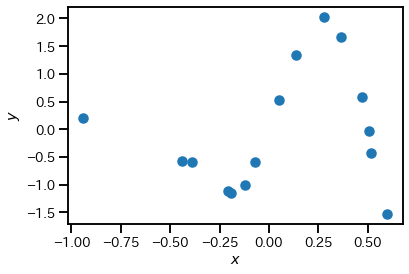

In [ ]:
import torch
torch.manual_seed(1)

# データ数
N = 15
# 説明変数（一様分布からサンプリング）
x_data = torch.FloatTensor(N).uniform_(-1, 1)

# 真の関数
def true_func(x):
    return 1.5*torch.exp(x) * torch.sin(2*torch.pi * x)

# 目的変数
y_data = true_func(x_data) + 0.1*torch.randn(N)

plt.scatter(x_data, y_data)
plt.xlabel('$x$')
plt.ylabel('$y$')

In [ ]:
import gpytorch
from gpytorch.models import ExactGP

In [ ]:
# ガウス過程回帰モデルの実装
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # 平均関数
        self.mean_module = gpytorch.means.ConstantMean()
        # カーネル関数
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    # ガウス過程の生成過程
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 尤度にガウス分布を設定
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# モデルのインスタンス化
model = ExactGPModel(x_data, y_data, likelihood)

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


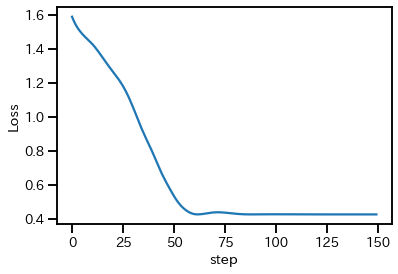

In [ ]:
# ハイパーパラメータ学習モードに設定
model.train()
likelihood.train()

# optimizerにAdamを設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

# 周辺対数尤度の計算
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
loss_list = []
for i in range(training_iter):
    # 勾配を0に初期化
    optimizer.zero_grad()
    # モデルからの出力
    output = model(x_data)
    # 損失関数の計算
    loss = -mll(output, y_data)
    # 勾配計算
    loss.backward()
    # パラメータ更新
    optimizer.step()
    loss_list.append(loss.detach().numpy())
    #loss_list.append(loss)

plt.plot(loss_list)
plt.xlabel('step')
plt.ylabel('Loss');

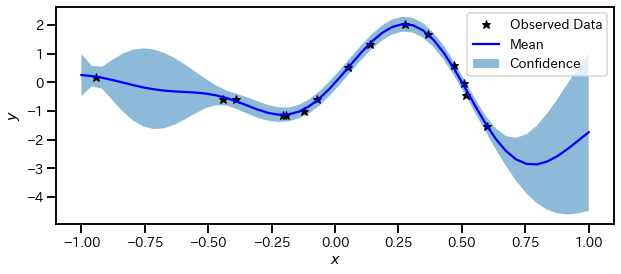

In [ ]:
# 推論モードに設定
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # テストデータの用意
    x_new = torch.linspace(-1, 1, 50)
    # 予測分布の出力
    prediction = likelihood(model(x_new))
    # 信用区間の出力
    lower, upper = prediction.confidence_region()
         
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', label='Observed Data')
ax.plot(x_new.numpy(), prediction.mean.numpy(), 'b', label='Mean')
ax.fill_between(x_new.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend();

In [ ]:
%load_ext watermark
%watermark --iversions

matplotlib         : 3.2.2
seaborn            : 0.11.2
numpy              : 1.21.6
japanize_matplotlib: 1.1.3
arviz              : 0.12.1
gpytorch           : 1.6.0
IPython            : 5.5.0
pandas             : 1.3.5
torch              : 1.11.0+cu113
scipy              : 1.4.1

